# <font color='#FF3300'>Convolutional Neural Network: Cat-Dog Classifier</font>
**개요**
- 고양이와 강아지 이미지를 분류하는 네트워크를 학습

**데이터셋**
- 강아지-고양이 이미지 데이터셋 [원본 출처](https://www.kaggle.com/c/dogs-vs-cats/data)
- 원본 데이터셋에는 고양이와 강아지 이미지가 각각 12500개로 총 25000개의 학습용 데이터셋이 구성
- 여기선 *훈련용 데이터가 class당 1000*개, *검증용 데이터가 class당 500*개, 마지막으로 *테스트용 데이터는 class당 1000개로 구성*되어 있음   
  - 여기선 훨씬 더 적은 양의 데이터만 사용 -> Transfer Learning 적용, Data Augmentation 목적도 있음

**목표**
- CNN을 설계하고 이미지 분류기를 학습
- 학습 과정에서 데이터 증식(data augmentation)을 적용
- 학습된 모델을 저장하고 로딩
- 전이학습(transfer learning)을 구현

    
**이번 과정을 통해 얻는 최종 결과물**

<img src="http://drive.google.com/uc?export=view&id=12IySBKqWiWdBR-IjkKWW41czlAjEqm5U" width="800px" height="300px" />
<center>&lt;CNN을 통해 강아지와 고양이분류를 구현합니다&gt;</center></caption>

# <font color='#FF3300'>PROCESS</font>
1. Package load
2. 데이터셋 다운로드 및 훈련, 검증, 테스트 데이터셋 구성
3. 하이터파라미터 구성
4. Dataset 및 DataLoader 할당
  - Data Augmentation
5. 네트워크 설계
6. Train, Validation, Test 함수 정의
7. 모델 저장 함수 정의
8. 모델 생성 및 Loss function, Optimizer 정의
9. Training
10. 저장된 모델 불러오기 및 Test
11. Transfer Learning
  - pretrained resnet50

In [ ]:
# from google.colab import auth
# auth.authenticate_user()

# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=False)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [14]:
import os
from pathlib import Path

# folder 변수에 구글드라이브에 프로젝트를 저장한 디렉토리를 입력
folder = "Project/"
project_dir = "CNN_PT"

base_path = Path("/content/drive/MyDrive/")
project_path = base_path / folder / project_dir
os.chdir(project_path)
for x in list(project_path.glob("*")):
    if x.is_dir():
        dir_name = str(x.relative_to(project_path))
        os.rename(dir_name, dir_name.split(" ", 1)[0])
print(f"현재 디렉토리 위치: {os.getcwd()}")

현재 디렉토리 위치: /content/drive/MyDrive/Project/CNN_PT


In [15]:
import torch 
print('pytorch version: {}'.format(torch.__version__))

pytorch version: 1.9.0+cu102


## 1. Package load

In [16]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

print('pytorch version: {}'.format(torch.__version__))
print('GPU 사용 가능 여부: {}'.format(torch.cuda.is_available()))
device = "cuda" if torch.cuda.is_available() else "cpu"   # GPU 사용 가능 여부에 따라 device 정보 저장

torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

pytorch version: 1.9.0+cu102
GPU 사용 가능 여부: True


## 2. 데이터셋 다운로드 및 훈련, 검증, 테스트 데이터셋 구성
- 이미지를 모아놓은 압축파일을 압축해제

In [18]:
import zipfile
from pathlib import Path

current_path = Path().absolute()
data_path = current_path / "data"
print("현재 디렉토리 위치: {}".format(current_path))

if (data_path / "my_cat_dog").exists():
    print("이미 'data/my_cat_dog' 폴더에 압축이 풀려있습니다. 확인해보세요!")
else:
    with zipfile.ZipFile(str(data_path / "my_cat_dog.zip"), "r") as zip_ref:
        zip_ref.extractall(str(data_path / "my_cat_dog"))
    print("Done!")

현재 디렉토리 위치: /content/drive/MyDrive/Project/CNN_PT
Done!


In [19]:
data_dir = './data/my_cat_dog'  # 압축 해제된 데이터셋의 디렉토리 경로

In [20]:
all_train_cat = glob.glob(os.path.join(data_dir, 'train', 'cat', '*'))
all_train_dog = glob.glob(os.path.join(data_dir, 'train', 'dog', '*'))
all_val_cat = glob.glob(os.path.join(data_dir, 'val', 'cat', '*'))
all_val_dog = glob.glob(os.path.join(data_dir, 'val', 'dog', '*'))
all_test_cat = glob.glob(os.path.join(data_dir, 'test', 'cat', '*'))
all_test_dog = glob.glob(os.path.join(data_dir, 'test', 'dog', '*'))

print('훈련용 고양이 이미지 개수:', len(all_train_cat))
print('훈련용 강아지 이미지 개수:', len(all_train_dog))
print('검증용 고양이 이미지 개수:', len(all_val_cat))
print('검증용 강아지 이미지 개수:', len(all_val_dog))
print('테스트용 고양이 이미지 개수:', len(all_test_cat))
print('테스트용 강아지 이미지 개수:', len(all_test_dog))

훈련용 고양이 이미지 개수: 1000
훈련용 강아지 이미지 개수: 1000
검증용 고양이 이미지 개수: 500
검증용 강아지 이미지 개수: 500
테스트용 고양이 이미지 개수: 1000
테스트용 강아지 이미지 개수: 1000


## 3. 하이퍼파라미터 세팅

In [21]:
batch_size = 100
num_epochs = 15
learning_rate = 0.0001

## 4. Dataset 및 DataLoader 할당

In [22]:
class CatDogDataset(Dataset):

    def __init__(self, data_dir, mode, transform=None):
        self.all_data = sorted(glob.glob(os.path.join(data_dir, mode, '*', '*')))
        self.transform = transform
    
    
    def __getitem__(self, index):

        # 1: 반환할 이미지 경로 정의 및 이미지 로드

        data_path = self.all_data[index]    
        img = Image.open(data_path)         
        img = self.transform(img)               
        


        # 2 : 이미지에 대한 label 정의

        name = os.path.basename(data_path)
        if name.startswith('cat'):
            label = 0
        else : label = 1
        return img, label
    

        # 3 : 이미지 총 길이 반환
    def __len__(self):
        length = len(self.all_data)
        return length

### 데이터 증식(Data Augmentation) 

적은 양의 훈련 데이터를 통해 학습시킨 모델은 오버피팅의 문제가 매우 심각할 수 있습니다. 
- 데이터 증식(data augmentation) 기법은 이러한 작은 데이터셋의 한계를 어느정도 극복하기 위한 좋은 방법 
- 데이터 증식은 기존의 데이터에 약간의 변형을 가해 데이터의 총량을 증식시키는 효과를 주는 기법    
----   
     
**데이터 증식을 통한 학습과정을 도식화**

<img src="http://drive.google.com/uc?export=view&id=1b0o9nVH8sDQyv_jSvRjjm5WT0jQ6XYxH" width="600px" height="400px" />

**data_transforms** 딕셔너리에는 훈련용, 검증용(또는 테스트용) transforms 모듈이 정의되어 있습니다. 
- 훈련용 transforms 모듈에서는 총 3가지의 데이터 증식 기법과, 이미지를 0~1 사이의 값으로 정규화하고 PyTorch Tensor로 변환하는 [ToTensor()](https://pytorch.org/docs/stable/torchvision/transforms.html?highlight=totensor#torchvision.transforms.ToTensor), 그리고 주어진 평균과 표준편차 값으로 입력값을 normalize 하는 [Normalize()](https://pytorch.org/docs/stable/torchvision/transforms.html?highlight=normalize#torchvision.transforms.Normalize)가 포함
  - 훈련용 데이터에 대해 각가 기법이 차례대로 적용된 후, ToTensor()와 Normalize()가 적용됨. 
  - 이 평균과 표준편차는 대규모 이미지 데이터셋인 [ImageNet](http://www.image-net.org/)의 평균과 표준편차
- 검증 또는 테스트를 진행하는 경우에는, 실행할 때마다 일관된 결과가 나오도록 하기 위해 데이터 증식 기법을 적용하지 않음.
  - 하지만 [trasnforms.Resize](https://pytorch.org/docs/stable/torchvision/transforms.html?highlight=resize#torchvision.transforms.Resize)을 통해 마찬가지로 120x120으로 이미지 크기를 고정해주도록 합니다. 

-----
**여기서 사용된 데이터 증식 기법에 대한 설명**.    
데이터 증식 기법에는 여러가지가 있음 
- 모델 훈련과정에서 다양한 증식 기법을 랜덤하게 적용하여 훈련용 데이터를 증식하는 효과를 얻을 것
- **transforms.RandomRotation**: 주어진 범위 사이의 각도 중에서 무작위로 이미지를 회전
- **transforms.RandomHorizontalFlip**: 주어진 확률로 이미지를 좌우 반전
- **transforms.RandomResizedCrop**: 주어진 scale과 ratio를 통해 이미지 크기를 조정하고 잘라낸 후에, 주어진 이미지 크기로 다시 resize 
----
우리가 가진 원본 데이터는 이미지마다 크기가 다르기 때문에 모델에 입력으로 주기 위해서는 반드시 일정한 크기로 맞추어야 함 
- 여기 모델에서는 120x120로 입력 이미지의 크기를 고정

**각각의 기법을 적용한 예시**

<img src="http://drive.google.com/uc?export=view&id=1wvJplIH2Ky04-75m8I6g5lmCO6fcx16I" width="800px" height="200px" />






In [23]:
data_transforms = {

    'train': transforms.Compose([
        transforms.RandomRotation(5),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(120, scale=(0.96, 1.0), ratio=(0.95, 1.05)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize([120, 120]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

train_data = CatDogDataset(data_dir='./data/my_cat_dog', mode='train', transform=data_transforms['train'])
val_data = CatDogDataset(data_dir='./data/my_cat_dog', mode='val', transform=data_transforms['val'])
test_data = CatDogDataset(data_dir='./data/my_cat_dog', mode='test', transform=data_transforms['val'])

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=True)

## 5. 네트워크 설계


In [24]:
class SimpleCNN(nn.Module):

    def __init__(self):
        super().__init__()

        # self.conv 구현
        self.conv = nn.Sequential(

            nn.Conv2d(3,32,3),    # conv_1 해당하는 층
            nn.BatchNorm2d(32),    # batch_norm_1 해당하는 층
            nn.ReLU(),    # ReLU_1 해당하는 층
            nn.MaxPool2d(2),    # maxpool_1 해당하는 층
            
            nn.Conv2d(32,64,3),    # conv_2 해당하는 층
            nn.BatchNorm2d(64),    # batch_norm_2 해당하는 층
            nn.ReLU(),    # ReLU_2 해당하는 층
            nn.MaxPool2d(2),    # maxpool_2 해당하는 층
            
            nn.Conv2d(64,128,3),    # conv_3 해당하는 층
            nn.BatchNorm2d(128),    # batch_norm_3 해당하는 층 
            nn.ReLU(),    # ReLU_3 해당하는 층
            nn.MaxPool2d(2),    # maxpool_3 해당하는 층
            
            nn.Conv2d(128,128,3),    # conv_4 해당하는 층
            nn.BatchNorm2d(128),    # batch_norm_4 해당하는 층
            nn.ReLU(),    # ReLU_4 해당하는 층
            nn.MaxPool2d(2),    # maxpool_4 해당하는 층
        )
        
        # self.fc 구현
        self.fc1 = nn.Linear(128*5*5, 512)
        self.fc2 = nn.Linear(512,2)
    
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.shape[0], -1) # Flatten
        x = F.relu(self.fc1(x)) # 1번째 fc layer에서 사용될 relu 활성화 함수를 함수 형태로 묶어보기
        x = self.fc2(x)
        return x

## 6. train, validation, test 함수 정의


### <font color='#D2691E'>Train 함수</font>

In [26]:
def train(num_epochs, model, data_loader, criterion, optimizer, saved_dir, val_every, device):

    print('Start training..')

    best_loss = 9999999

    for epoch in range(num_epochs):

        for i, (imgs, labels) in enumerate(data_loader):

            imgs, labels = imgs.to(device), labels.to(device)

            outputs = model(imgs)  
            loss = criterion(outputs, labels)    

            optimizer.zero_grad()           # 이전에 계산한 기울기 모두 clear
            loss.backward()            # 오차 역전파를 통해 기울기 계산
            optimizer.step()            # 옵티마이저를 통해 Parameters 업데이트

            _, argmax = torch.max(outputs, 1)
            accuracy = (labels == argmax).float().mean()

            if (i+1) % 3 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'.format(
                    epoch+1, num_epochs, i+1, len(data_loader), loss.item(), accuracy.item() * 100))



        # 일정한 epoch마다  `validation` 함수를 통해 검증을 수행
        # 모델 검증을 수행했을 때, 만약 검증 과정의 평균 loss가 현재까지 가장 낮다면 가장 잘 훈련된 모델로 가정하고 그때까지 학습한 모델을 저장 
        # 저장은 추후에 구현할 `save_model` 함수가 수행
        
        if (epoch + 1) % val_every == 0:
            avrg_loss = validation(epoch + 1, model, val_loader, criterion, device)
            if avrg_loss < best_loss:
                print('Best performance at epoch: {}'.format(epoch + 1))
                print('Save model in', saved_dir)
                best_loss = avrg_loss
                save_model(model, saved_dir)

### <font color='#D2691E'>Validation 함수</font>

In [31]:
def validation(epoch, model, data_loader, criterion, device):

    print('Start validation #{}'.format(epoch) )

    model.eval() # 모델 검증 과정에서는 모델을 evaluation 모드로 작동해야함 : Batch Normalization과 Dropout은 훈련과 검증시에 동하는 방식이 다름

    with torch.no_grad():
        total = 0
        correct = 0
        total_loss = 0
        cnt = 0

        for i, (imgs, labels) in enumerate(data_loader):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            total += imgs.size(0)
            _, argmax = torch.max(outputs, 1)
            correct += (labels == argmax).sum().item()
            total_loss += loss
            cnt += 1


        # 검증 과정에서는 파라미터 업데이트를 하지 않기 때문에 기울기 계산 필요 X
        # 검증 과정에서의 평균 loss를 계산하기 위해 loss는 계산해야 함

        avrg_loss = total_loss / cnt
        print('Validation #{}  Accuracy: {:.2f}%  Average Loss: {:.4f}'.format(epoch, correct / total * 100, avrg_loss))

    model.train() # model.eval() 검증 끝나고 model.train() 으로 변경 필요
    return avrg_loss

### <font color='#D2691E'>Test 함수</font>

In [32]:
def test(model, data_loader, device):

    print('Start test..')

    model.eval()

    with torch.no_grad():

        correct = 0
        total = 0


        # 테스트에서는 loss를 계산할 필요가 없음
        # 전체 정확도를 통해 모델의 성능을 확인
        
        for i, (imgs, labels) in enumerate(data_loader):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, argmax = torch.max(outputs, 1)    # max()를 통해 최종 출력이 가장 높은 class 선택
            total += imgs.size(0)
            correct += (labels == argmax).sum().item()

        print('Test accuracy for {} images: {:.2f}%'.format(total, correct / total * 100))
    model.train()

## 7. 모델 저장 함수 정의 
- 모델 저장은 `torch.save`함수를 통해 할 수 있음 
- `nn.Module.state_dict`를 통해 Module, 즉 내 모델의 파라미터를 가져올 수 있음. - 이렇게 불러온 파라미터를 `check_point 딕셔너리에 저장`
-  **check_point**를 정해준 경로에 저장 

[PyTorch 공식 튜토리얼](https://pytorch.org/tutorials/beginner/saving_loading_models.html)에서 모델을 저장하고 불러오는 방법에 대한 예제를 확인

`torch.save` 는 단순히 모델의 파라미터만 저장하는 함수가 아님
- 어떤 파이썬 객체든 저장
  - 그래서 경우에 따라 **check_point** 딕셔너리에 모델의 파라미터 뿐만 아니라 다른 여러 가지 필요한 정보를 저장 가능
  - 예를 들어 총 몇 에폭동안 학습한 모델인지 그 정보도 저장 가능 


In [28]:
def save_model(model, saved_dir, file_name='best_model.pt'):
    os.makedirs(saved_dir, exist_ok=True)
    check_point = {
        'net': model.state_dict()
    }
    output_path = os.path.join(saved_dir, file_name)
    torch.save(check_point, output_path)

## 8. 모델 생성 및 Loss function, Optimizer 정의

In [29]:
torch.manual_seed(777) # 일관된 weight initialization을 위한 random seed 설정

model = SimpleCNN()          
model = model.to(device)

criterion = nn.CrossEntropyLoss()     
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)     

val_every = 1 # 검증을 몇 에폭마다 진행할지 정하는 변수
saved_dir = './saved/SimpleCNN' # 모델이 저장될 디렉토리의 경로

## 9. Training

 첫 에폭 학습후에 ./saved/SimpleCNN 경로(saved_dir)에 best_model.pt 파일이 저장됨

In [33]:
train(num_epochs, model, train_loader, criterion, optimizer, saved_dir, val_every, device)

Start training..
Epoch [1/15], Step [3/20], Loss: 0.5935, Accuracy: 65.00%
Epoch [1/15], Step [6/20], Loss: 0.6417, Accuracy: 60.00%
Epoch [1/15], Step [9/20], Loss: 0.6487, Accuracy: 60.00%
Epoch [1/15], Step [12/20], Loss: 0.6472, Accuracy: 65.00%
Epoch [1/15], Step [15/20], Loss: 0.6211, Accuracy: 70.00%
Epoch [1/15], Step [18/20], Loss: 0.6352, Accuracy: 61.00%
Start validation #1
Validation #1  Accuracy: 67.50%  Average Loss: 0.5977
Best performance at epoch: 1
Save model in ./saved/SimpleCNN
Epoch [2/15], Step [3/20], Loss: 0.5805, Accuracy: 69.00%
Epoch [2/15], Step [6/20], Loss: 0.5139, Accuracy: 81.00%
Epoch [2/15], Step [9/20], Loss: 0.5432, Accuracy: 74.00%
Epoch [2/15], Step [12/20], Loss: 0.5871, Accuracy: 67.00%
Epoch [2/15], Step [15/20], Loss: 0.5739, Accuracy: 63.00%
Epoch [2/15], Step [18/20], Loss: 0.5678, Accuracy: 73.00%
Start validation #2
Validation #2  Accuracy: 69.10%  Average Loss: 0.5714
Best performance at epoch: 2
Save model in ./saved/SimpleCNN
Epoch [3/15

## 10. 저장된 모델 불러오기 및 test

In [34]:
model_path = './saved/SimpleCNN/best_model.pt'
model = SimpleCNN().to(device)   # 아래의 모델 불러오기를 정확히 구현했는지 확인하기 위해 새로 모델을 선언하여 학습 이전 상태로 초기화

# model_path의 경로에 있는 모델 파일을 로드하여, 이를 check_point 변수에 저장
checkpoint = torch.load(model_path, map_location=device)    

# check_point 딕셔너리에 접근하여 모델의 파라미터를 state_dict 변수에 저장. 접근을 위한 딕셔너리의 키값은 'net'
state_dict = checkpoint['net']    

# state_dict의 파라미터들을 새로 선언한 모델(model)에 로드
model.load_state_dict(state_dict)                

<All keys matched successfully>

마지막으로 모델의 성능을 테스트

In [35]:
test(model, test_loader, device)

Start test..
Test accuracy for 2000 images: 77.40%


학습된 모델의 예측 결과를 시각화
- 괄호안에 'O'가 있는 경우, 모델이 정확한 예측을 한 것이고 'X'인 경우는 틀린 예측을 한 것

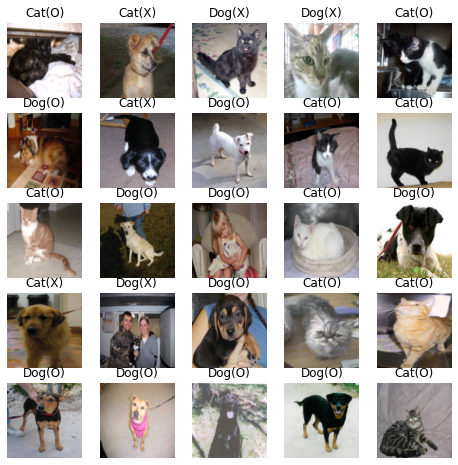

In [36]:
columns = 5
rows = 5
fig = plt.figure(figsize=(8,8))

model.eval()

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
for i in range(1, columns*rows+1):
    data_idx = np.random.randint(len(test_data))
    input_img = test_data[data_idx][0].unsqueeze(dim=0).to(device) 
    '''
    unsqueeze()를 통해 입력 이미지의 shape을 (1, 28, 28)에서 (1, 1, 28, 28)로 변환. 
    모델에 들어가는 입력 이미지의 shape은 (batch_size, channel, width, height) 되어야 함에 주의
    '''
    output = model(input_img)
    _, argmax = torch.max(output, 1)
    pred = argmax.item()
    label = test_data[data_idx][1]
    
    fig.add_subplot(rows, columns, i)
    pred_title = 'Cat' if pred == 0 else 'Dog'
    if pred == label:
        plt.title(pred_title + '(O)')
    else:
        plt.title(pred_title + '(X)')

    plot_img = test_data[data_idx][0]
    
    # 이미지를 normalization 이전 상태로 되돌리는 작업
    plot_img[0, :, :] = plot_img[0, :, :] * std[0] + mean[0]
    plot_img[1, :, :] = plot_img[1, :, :] * std[1] + mean[1]
    plot_img[2, :, :] = plot_img[2, :, :] * std[2] + mean[2]
    plot_img = transforms.functional.to_pil_image(plot_img)
    plt.imshow(plot_img)
    plt.axis('off')
plt.show()

## 11. Transfer Learning

**전이학습**
- 비슷한 목적으로 미리 학습된 모델의 파라미터로 나의 모델의 파라미터를 초기화한 후 학습을 이어서 진행하는 것

**장점**
- 현실에서 딥러닝을 활용할 때 흔히 마주칠 수 있는 현실적인 제약들이 있습니다.
  - 데이터 부족, 컴퓨팅 리소스 부족, 시간의 부족이 대표적인 현실적인 제약들에 속함 
  - 풀고자 하는 문제와 완전히 똑같지는 않지만 어느정도 연관성이 있는 문제를, 아주 많은 양의 데이터로, 미리 학습한 모델이 있다면 그 모델은 정말 아무것도 모르는 백지 상태의 모델보다 내가 풀고 싶은 문제에 대해 훨씬 더 빨리 배우고 잘 배울 수 있음


여기서 불러올 모델은 **ResNet으로, 대규모 ImageNet 데이터로 이미지 분류를 학습한 모델**

In [37]:
#  torchvision에 구현된 resnet50을 파라미터가 학습된 상태로 불러오기

new_model = torchvision.models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

앞서 직접 정의한 모델(SimpleCNN)에서는 입력 이미지의 크기를 120x120로 한 것에 반해, 방금 불러온 ResNet은 입력 이미지 크기를 최소한 224x224로 가정하고 학습된 모델 
- 따라서 입력 데이터 크기만 수정하여 DataLoader를 다시 정의

In [38]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(5),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(224, scale=(0.96, 1.0), ratio=(0.95, 1.05)), # resnet에 맞게 사이즈 변경 224x224
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize([224, 224]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

train_data = CatDogDataset(data_dir='./data/my_cat_dog', mode='train', transform=data_transforms['train'])
val_data = CatDogDataset(data_dir='./data/my_cat_dog', mode='val', transform=data_transforms['val'])
test_data = CatDogDataset(data_dir='./data/my_cat_dog', mode='test', transform=data_transforms['val'])

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=True)

In [39]:
new_model.fc.in_features

2048

In [40]:
# resnet50.parameters를 통해 모델 파라미터에 대한 iterator를 가져오기
# 이 iterator를 통해 for문을 돌며 모든 파라미터에 대해 requires_grad를 False로 바꿔줌
# 이렇게 하면 이 파라미터들에 대해서는 기울기가 계산되지 않기 때문에, 파라미터 업데이트가 되지 않음
for param in new_model.parameters():
    param.requires_grad = False

# resnet50.fc에 접근해 resnet50의 마지막 레이어(fc)의 입력 뉴런 수 가져오기 
num_ftrs = new_model.fc.in_features # 2048

# resnet50의 마지막 입력 뉴런 수를 가져오고 출력 뉴런 수는 프로젝트에 맞게 class 2개로 변경
new_model.fc = nn.Linear(num_ftrs, 2)   


criterion = nn.CrossEntropyLoss() # softmax internally computed     
new_model = new_model.to(device)
optimizer = torch.optim.Adam(new_model.parameters(), lr=learning_rate)      


val_every = 1
saved_dir = './saved/ResNet50'

resnet50을 활용해 전이학습 수행

In [41]:
train(num_epochs, new_model, train_loader, criterion, optimizer, saved_dir, val_every, device)

Start training..
Epoch [1/15], Step [3/20], Loss: 0.6487, Accuracy: 64.00%
Epoch [1/15], Step [6/20], Loss: 0.6282, Accuracy: 68.00%
Epoch [1/15], Step [9/20], Loss: 0.5772, Accuracy: 78.00%
Epoch [1/15], Step [12/20], Loss: 0.5678, Accuracy: 83.00%
Epoch [1/15], Step [15/20], Loss: 0.5287, Accuracy: 89.00%
Epoch [1/15], Step [18/20], Loss: 0.5094, Accuracy: 90.00%
Start validation #1
Validation #1  Accuracy: 92.10%  Average Loss: 0.4768
Best performance at epoch: 1
Save model in ./saved/ResNet50
Epoch [2/15], Step [3/20], Loss: 0.4864, Accuracy: 93.00%
Epoch [2/15], Step [6/20], Loss: 0.4527, Accuracy: 94.00%
Epoch [2/15], Step [9/20], Loss: 0.4500, Accuracy: 91.00%
Epoch [2/15], Step [12/20], Loss: 0.4131, Accuracy: 94.00%
Epoch [2/15], Step [15/20], Loss: 0.4468, Accuracy: 89.00%
Epoch [2/15], Step [18/20], Loss: 0.4043, Accuracy: 96.00%
Start validation #2
Validation #2  Accuracy: 95.80%  Average Loss: 0.3716
Best performance at epoch: 2
Save model in ./saved/ResNet50
Epoch [3/15],

전이 학습을 마친 후, 훈련 단계에서 최고 성능을 보인 파라미터를 불러오고, 그 성능을 확인

In [42]:
model_path = './saved/ResNet50/best_model.pt'

checkpoint = torch.load(model_path, map_location=device)    
state_dict = checkpoint['net']    
new_model.load_state_dict(state_dict)                

<All keys matched successfully>

테스트를 수행
- 겨우 마지막 FC layer만 학습시켰음에도 불구하고 직접 정의한 SimpleCNN보다 성능이 훨씬 좋은 것을 볼 수 있음

In [43]:
test(new_model, test_loader, device)

Start test..
Test accuracy for 2000 images: 98.20%


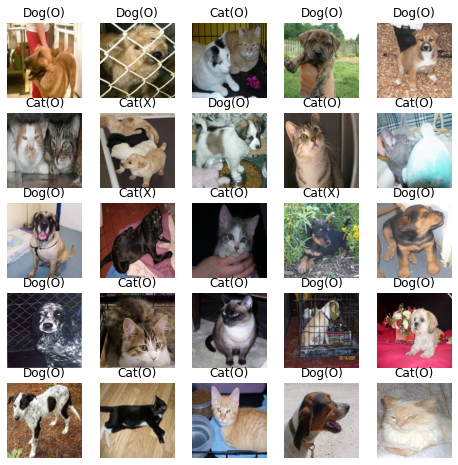

In [44]:
columns = 5
rows = 5
fig = plt.figure(figsize=(8,8))

model.eval()

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

for i in range(1, columns*rows+1):
    data_idx = np.random.randint(len(test_data))
    input_img = test_data[data_idx][0].unsqueeze(dim=0).to(device) 

    '''
    unsqueeze()를 통해 입력 이미지의 shape을 (1, 28, 28)에서 (1, 1, 28, 28)로 변환. 
    모델에 들어가는 입력 이미지의 shape은 (batch_size, channel, width, height) 되어야 함에 주의!
    '''

    output = new_model(input_img)
    _, argmax = torch.max(output, 1)
    pred = argmax.item()
    label = test_data[data_idx][1]
    
    fig.add_subplot(rows, columns, i)
    pred_title = 'Cat' if pred == 0 else 'Dog'
    if pred == label:
        plt.title(pred_title + '(O)')
    else:
        plt.title(pred_title + '(X)')
    plot_img = test_data[data_idx][0]
    


    # 이미지를 normalization 이전 상태로 되돌리는 작업

    plot_img[0, :, :] = plot_img[0, :, :] * std[0] + mean[0]
    plot_img[1, :, :] = plot_img[1, :, :] * std[1] + mean[1]
    plot_img[2, :, :] = plot_img[2, :, :] * std[2] + mean[2]
    plot_img = transforms.functional.to_pil_image(plot_img)
    plt.imshow(plot_img)
    plt.axis('off')

model.train()

plt.show()

---